In [1]:
!pip install torch transformers pandas scikit-learn numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

# Extract the zip file
def extract_data(zip_path="/content/data.zip", extract_to="/content/"):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted data from {zip_path} to {extract_to}")

    # Show dataset structure
    for root, dirs, files in os.walk("/content/data"):
        level = root.replace("/content/data", "").count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        if level == 2:  # Don't show individual files to keep output clean
            num_files = len(files)
            print(f"{indent}    [{num_files} image files]")

# Custom dataset class to handle the specific folder structure
class AnimalDataset(Dataset):
    def __init__(self, root_dir, animal_type, split, transform=None):
        """
        Args:
            root_dir: Root directory of the dataset
            animal_type: 'chicken' or 'duck'
            split: 'train', 'val', or 'test'
            transform: Optional transform to be applied on images
        """
        self.image_dir = os.path.join(root_dir, f"{animal_type}-images", split)
        self.transform = transform
        self.label = 0 if animal_type == 'chicken' else 1  # 0: chicken, 1: duck
        self.image_paths = [os.path.join(self.image_dir, img) for img in os.listdir(self.image_dir)
                           if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, self.label

# Function to create combined datasets and dataloaders
def create_data_loaders(root_dir="/content/data", batch_size=16):
    # Define transformations
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    eval_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Create datasets for each split
    train_chicken = AnimalDataset(root_dir, 'chicken', 'train', train_transform)
    train_duck = AnimalDataset(root_dir, 'duck', 'train', train_transform)

    val_chicken = AnimalDataset(root_dir, 'chicken', 'val', eval_transform)
    val_duck = AnimalDataset(root_dir, 'duck', 'val', eval_transform)

    test_chicken = AnimalDataset(root_dir, 'chicken', 'test', eval_transform)
    test_duck = AnimalDataset(root_dir, 'duck', 'test', eval_transform)

    # Combine datasets
    class CombinedDataset(Dataset):
        def __init__(self, *datasets):
            self.datasets = datasets
            self.lengths = [len(d) for d in datasets]
            self.cumulative_lengths = [sum(self.lengths[:i+1]) for i in range(len(self.lengths))]

        def __len__(self):
            return sum(self.lengths)

        def __getitem__(self, idx):
            dataset_idx = 0
            while dataset_idx < len(self.cumulative_lengths) and idx >= self.cumulative_lengths[dataset_idx]:
                dataset_idx += 1

            if dataset_idx == 0:
                return self.datasets[0][idx]
            else:
                return self.datasets[dataset_idx][idx - self.cumulative_lengths[dataset_idx-1]]

    # Create combined datasets
    train_dataset = CombinedDataset(train_chicken, train_duck)
    val_dataset = CombinedDataset(val_chicken, val_duck)
    test_dataset = CombinedDataset(test_chicken, test_duck)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Print dataset sizes
    print(f"Training set: {len(train_dataset)} images")
    print(f"Validation set: {len(val_dataset)} images")
    print(f"Test set: {len(test_dataset)} images")

    return train_loader, val_loader, test_loader

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=2):
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]') as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Calculate metrics
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Update progress bar
                pbar.set_postfix({
                    'loss': running_loss / (pbar.n + 1),
                    'acc': 100 * correct / total
                })

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            with tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]') as pbar:
                for inputs, labels in pbar:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

                    pbar.set_postfix({
                        'loss': val_loss / (pbar.n + 1),
                        'acc': 100 * val_correct / val_total
                    })

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'  Saved new best model with validation accuracy: {val_acc:.2f}%')

    return model, history

# Function to evaluate the model and generate classification report
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate and print classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("\nClassification Report:")
    print(report)

    # Generate and print confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add text annotations to the confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return report

# Function to visualize training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to visualize some predictions
def visualize_predictions(model, data_dir, class_names, device, num_samples=5):
    # Setup transformation
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Get some test images
    chicken_test_dir = os.path.join(data_dir, "chicken-images", "test")
    duck_test_dir = os.path.join(data_dir, "duck-images", "test")

    chicken_files = [os.path.join(chicken_test_dir, f) for f in os.listdir(chicken_test_dir)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    duck_files = [os.path.join(duck_test_dir, f) for f in os.listdir(duck_test_dir)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Select random samples from each class
    import random
    if len(chicken_files) > num_samples // 2:
        chicken_samples = random.sample(chicken_files, num_samples // 2)
    else:
        chicken_samples = chicken_files

    if len(duck_files) > num_samples // 2:
        duck_samples = random.sample(duck_files, num_samples // 2)
    else:
        duck_samples = duck_files

    samples = chicken_samples + duck_samples
    true_labels = [0] * len(chicken_samples) + [1] * len(duck_samples)

    # Make predictions
    model.eval()
    plt.figure(figsize=(15, 3*len(samples)))

    for i, (img_path, true_label) in enumerate(zip(samples, true_labels)):
        # Load and show the image
        img = Image.open(img_path).convert('RGB')
        plt.subplot(len(samples), 2, 2*i+1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_label]}")
        plt.axis('off')

        # Process image for prediction
        img_tensor = transform(img).unsqueeze(0).to(device)

        # Make prediction
        with torch.no_grad():
            outputs = model(img_tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)[0]
            _, predicted = torch.max(outputs, 1)
            predicted_label = predicted.item()

        # Plot probabilities
        plt.subplot(len(samples), 2, 2*i+2)
        bars = plt.bar(class_names, [probs[0].item() * 100, probs[1].item() * 100])
        plt.title(f"Predicted: {class_names[predicted_label]} ({probs[predicted_label]:.1f}%)")
        plt.ylim(0, 100)

        # Color the bars (green if correct, red if incorrect)
        bars[0].set_color('green' if predicted_label == 0 and true_label == 0 else
                         'red' if predicted_label == 0 and true_label != 0 else 'gray')
        bars[1].set_color('green' if predicted_label == 1 and true_label == 1 else
                         'red' if predicted_label == 1 and true_label != 1 else 'gray')

    plt.tight_layout()
    plt.show()

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set hyperparameters
batch_size = 16
num_epochs = 5
learning_rate = 0.001
class_names = ['chicken', 'duck']

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Extract data from zip file (if needed)
if not os.path.exists("/content/data"):
    extract_data()

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(batch_size=batch_size)

# Load a pre-trained model (ResNet-18)
model = models.resnet18(weights='IMAGENET1K_V1')

# Modify the final layer for our binary classification task
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# Move model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
print("\nTraining the model...")
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs)

Using device: cpu
Training set: 592 images
Validation set: 212 images
Test set: 200 images

Training the model...


Epoch 1/5 [Train]:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/5:
  Train Loss: 0.4848, Train Acc: 84.12%
  Val Loss: 0.6758, Val Acc: 78.30%
  Saved new best model with validation accuracy: 78.30%


Epoch 2/5 [Train]:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/5:
  Train Loss: 0.4138, Train Acc: 83.11%
  Val Loss: 0.2346, Val Acc: 93.87%
  Saved new best model with validation accuracy: 93.87%


Epoch 3/5 [Train]:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/5:
  Train Loss: 0.2930, Train Acc: 88.51%
  Val Loss: 0.5888, Val Acc: 80.66%


Epoch 4/5 [Train]:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/5:
  Train Loss: 0.2562, Train Acc: 89.70%
  Val Loss: 0.5134, Val Acc: 76.42%


Epoch 5/5 [Train]:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/5:
  Train Loss: 0.2370, Train Acc: 90.37%
  Val Loss: 0.1746, Val Acc: 93.87%


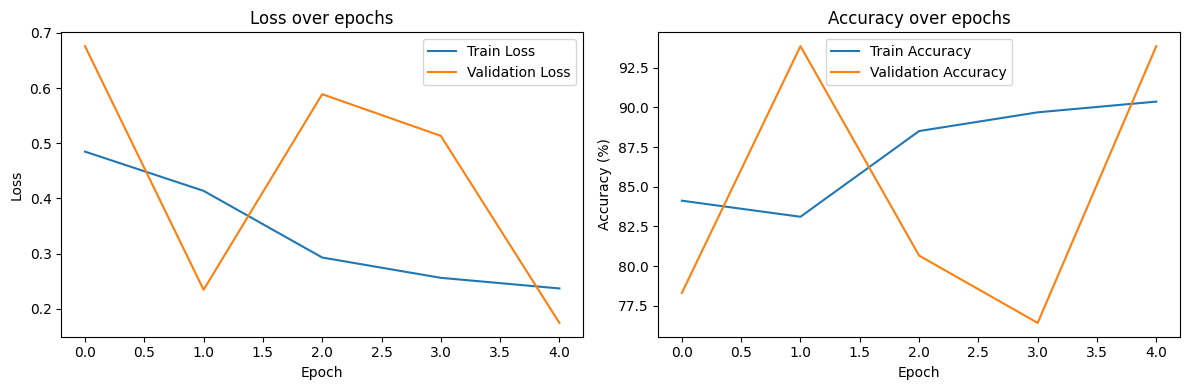


Evaluating the model on test set...


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

     chicken       0.87      0.95      0.91       102
        duck       0.94      0.85      0.89        98

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



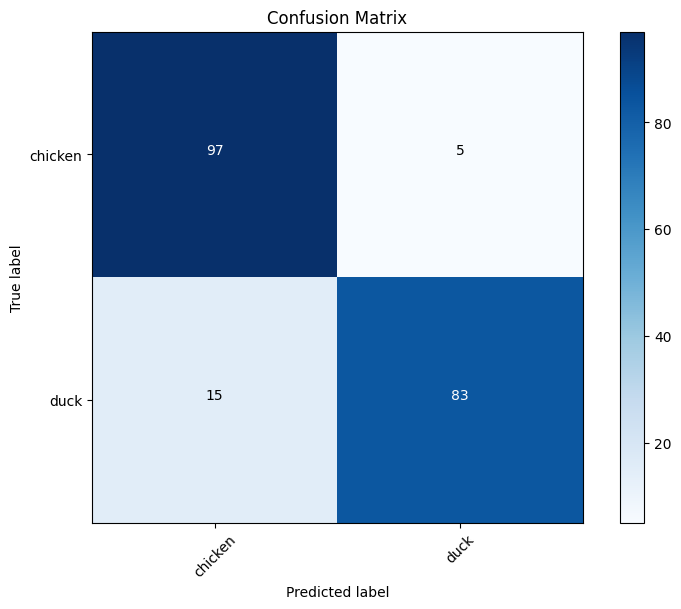


Visualizing some test predictions...


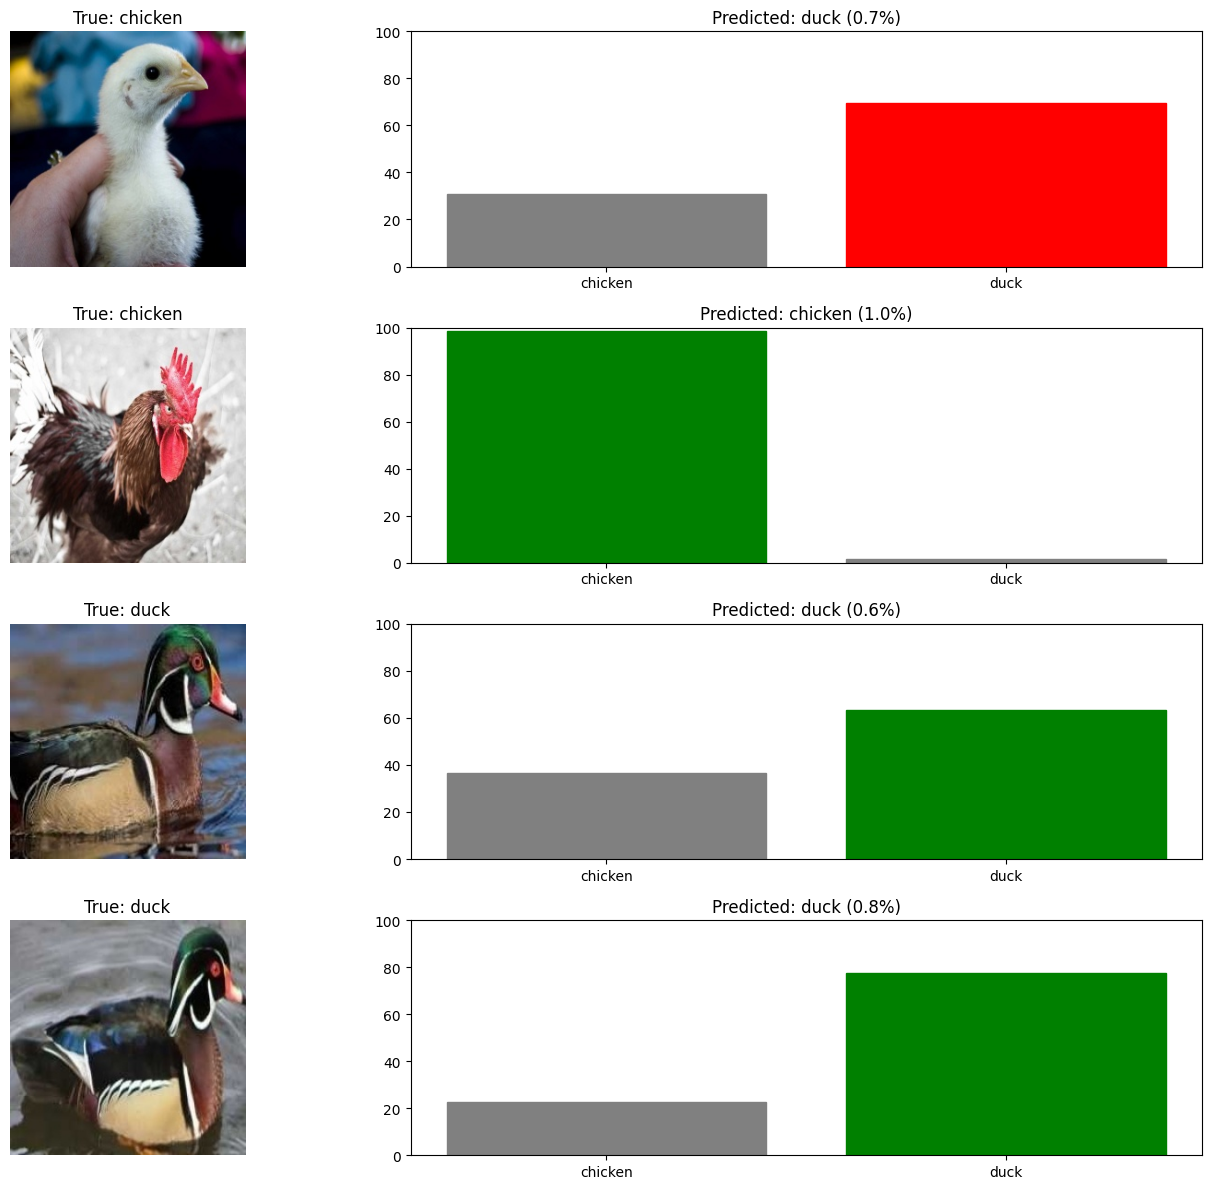

In [2]:
# Plot training history
plot_training_history(history)

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the model
print("\nEvaluating the model on test set...")
evaluate_model(model, test_loader, device, class_names)

# Visualize some predictions
print("\nVisualizing some test predictions...")
visualize_predictions(model, "/content/data", class_names, device)